# Inferring physical properties of stellar collapse by third-generation gravitational-wave detectors

 Data release companion python notebook

### Import Modules, define constants

In [1]:
import numpy
import h5py
import matplotlib.pyplot as plt
import glob

from pycbc.inference.io import loadfile
from pycbc.types import timeseries
from matplotlib import rcParams
from scipy.fftpack import fft
import scipy.interpolate
import scipy.spatial

/home/chaitanya.afle/src/pycbc/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

rcParams['figure.figsize'] = (14, 7)
rcParams['text.usetex'] = False
rcParams.update({'font.size': 15})

In [3]:
fs = 4.*4096.  # sample rate in Hz
delta_t = 1./fs

# Defining the 1 sec time array:
time_axis = numpy.arange(0.0, 1., delta_t)

# Defining the aligning times:
t_align = 0.5  # secs

distance_1kpc = 3.086*(10**19)
delta_f = 1./(len(time_axis)*delta_t)
flen = (len(time_axis) / 2) + 1
f_low = 20.

### Principal components

In [4]:
pc_file = h5py.File('principal_components_files/principal_components.hdf', 'r')

pc_betas = numpy.array(pc_file.get('betas'))
pcs = pc_file.get('principal_components')                                                                                                              
pcs = pcs[:15]
coeffs = numpy.array(pc_file.get('coefficients'))
pc_alpha1 = coeffs[:,0]
pc_alpha2 = coeffs[:,1]
pc_alpha3 = coeffs[:,2]
pc_alpha4 = coeffs[:,3]
pc_alpha5 = coeffs[:,4]
pc_alpha6 = coeffs[:,5]
pc_alpha7 = coeffs[:,6]
pc_alpha8 = coeffs[:,7]
pc_alpha9 = coeffs[:,8]
pc_alpha10 = coeffs[:,9]
pc_alpha11 = coeffs[:,10]
pc_alpha12 = coeffs[:,11]
pc_alpha13 = coeffs[:,12]
pc_alpha14 = coeffs[:,13]
pc_alpha15 = coeffs[:,14]
pc_file.close()

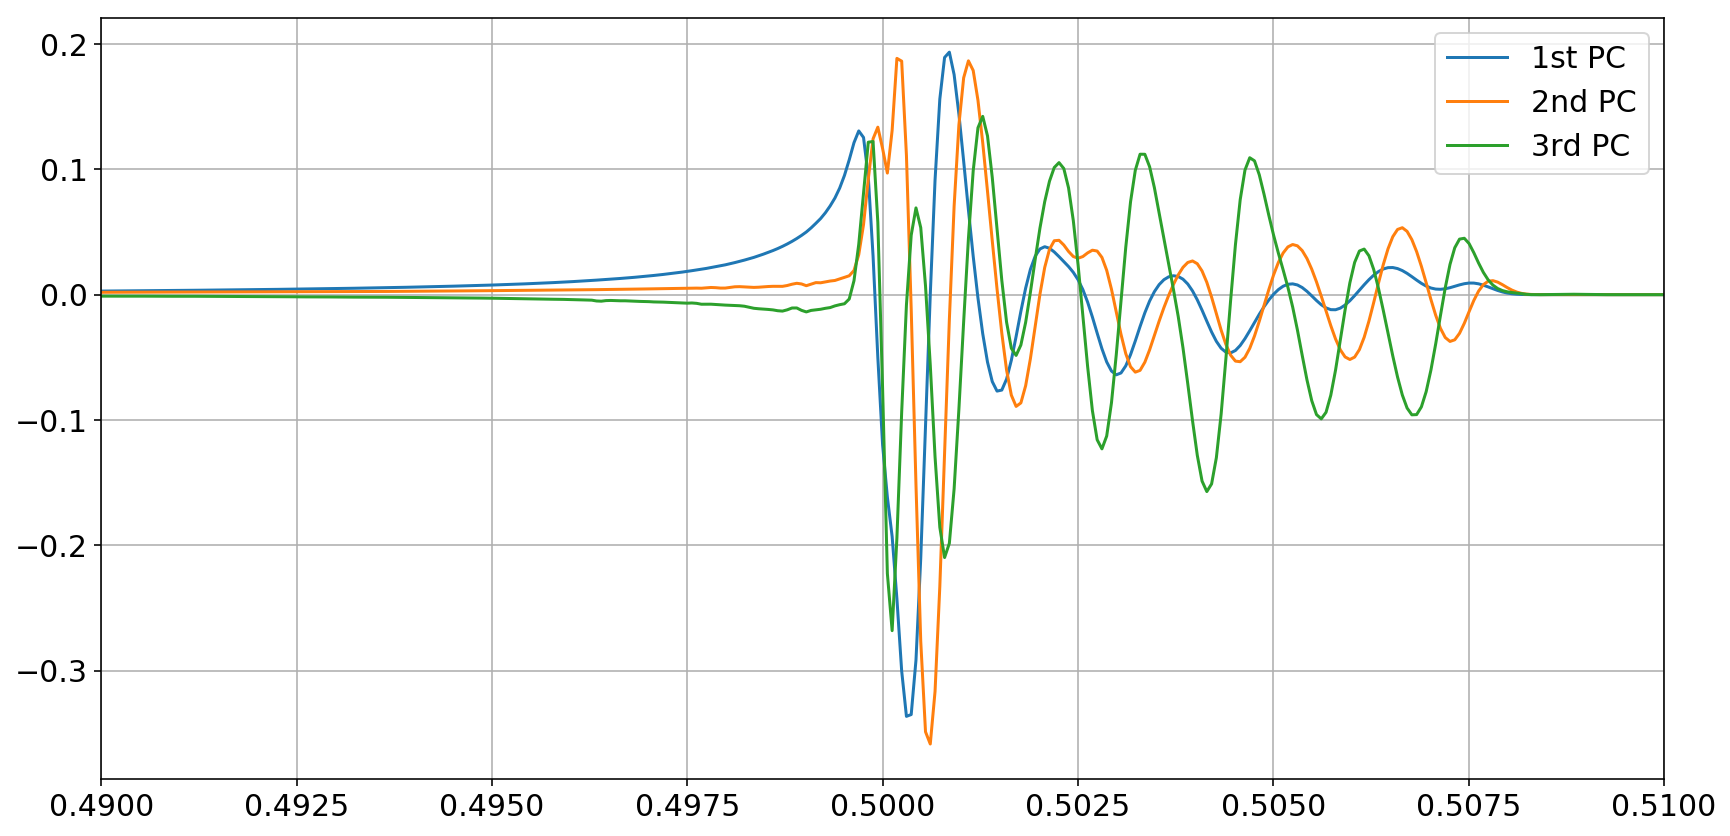

In [5]:
plt.plot(time_axis, pcs[0], label='1st PC')
plt.plot(time_axis, pcs[1], label='2nd PC')
plt.plot(time_axis, pcs[2], label='3rd PC')
plt.xlim(0.49, 0.51)
plt.grid(True)
plt.legend(loc='best')
plt.show()

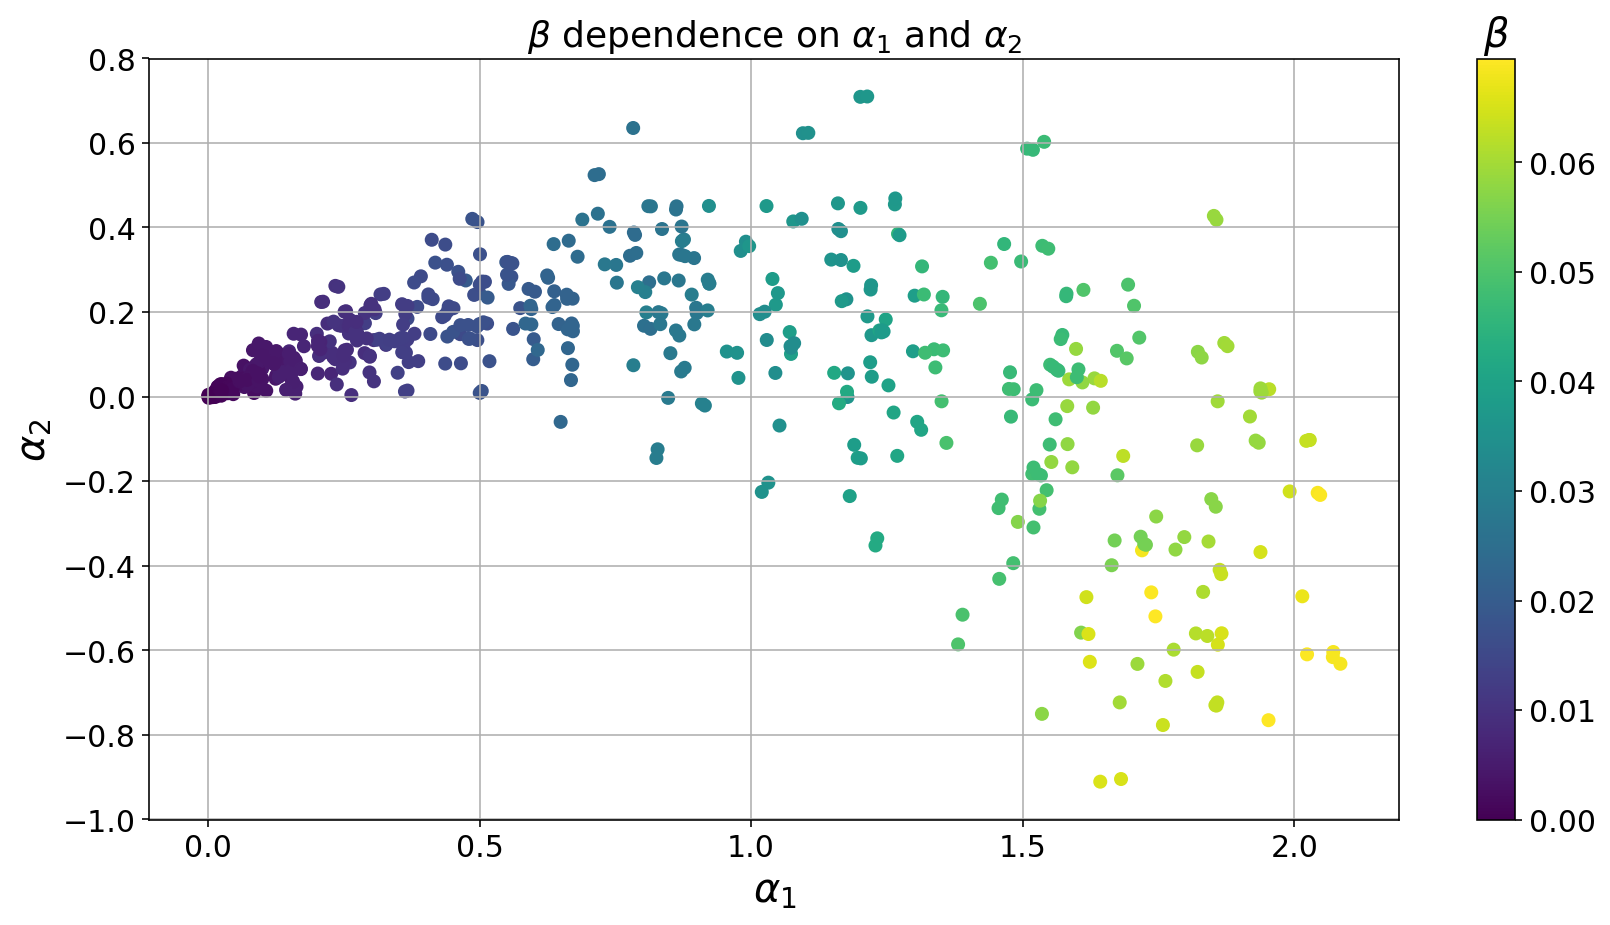

In [6]:
plt.scatter(coeffs[:,0], coeffs[:,1],
            c=pc_betas, cmap='viridis', marker='o')
plt.grid(True)
cbar = plt.colorbar()
cbar.ax.set_title(r'$\beta$', fontsize=20)

plt.ylabel(r'$\alpha_2$', fontsize=20)
plt.xlabel(r'$\alpha_1$', fontsize=20)
plt.title(r'$\beta$ dependence on $\alpha_1$ and $\alpha_2$')
plt.show()

### Function definitions for maps $\beta(\alpha_1, ..., \alpha_n)$ and $f_{\mathrm{peak}}(\alpha_1, ..., \alpha_n)$

In [7]:
def extract_samples_from_posteriors(posterior_filename):
    with h5py.File(posterior_filename, 'r') as fp:
            post_samples = {p: v[:] for p, v in fp['samples'].items()}
    return post_samples

In [8]:
def get_f_peak_from_strain(wf_key, detector_name, time_axis, delta_t, 
                           f_peak_lower_bound, f_peak_upper_bound, principal_components):
    
    samples = extract_samples_from_posteriors('posterior_files/{}_0.0081_{}.hdf'.format(detector_name, 
                                                                                        wf_key))
    fpeak = []
    for idx in range(len(samples['coeff_0'])):
        coeffs = numpy.array([samples['coeff_0'][idx], samples['coeff_1'][idx], 
                      samples['coeff_2'][idx], samples['coeff_3'][idx], 
                      samples['coeff_4'][idx], samples['coeff_5'][idx], 
                      samples['coeff_6'][idx], samples['coeff_7'][idx], 
                      samples['coeff_8'][idx], samples['coeff_9'][idx], 
                      samples['coeff_10'][idx], samples['coeff_11'][idx], 
                      samples['coeff_12'][idx], samples['coeff_13'][idx], 
                      samples['coeff_14'][idx]])

        wf_strain = numpy.dot(coeffs, principal_components)
        wf_fft = fft(wf_strain)
        wf_fft = numpy.abs(wf_fft[0:len(time_axis)//2])
        freqs = numpy.linspace(0.0, 1.0/(2.0*delta_t), len(time_axis)//2)
        f_peak_determined_index = numpy.argmax(wf_fft[numpy.where(
            freqs > f_peak_lower_bound) and numpy.where(freqs < f_peak_upper_bound)])
        f_peak = freqs[f_peak_determined_index]
        fpeak.append(f_peak)
        
    return fpeak


def get_beta_from_alpha1_alpha_2(wf_key, detector_name, pc_alpha_1, pc_alpha_2, pc_beta_values):
    
    samples = extract_samples_from_posteriors('posterior_files/{}_0.0081_{}.hdf'.format(detector_name, 
                                                                                        wf_key))
    beta = scipy.interpolate.griddata(numpy.transpose([pc_alpha_1, pc_alpha_2]), pc_beta_values,
                                      numpy.transpose([samples['coeff_0'], samples['coeff_1']]), 
                                      method='linear')
    return beta

### Using the maps on $\alpha_i$ posteriors to get posterior probability distribution for $\beta$ and $f_{peak}$ 

In [9]:
keys = ['A467w3.00_SFHx', 'A634w3.50_GShenFSU1.7', 
        'A1268w3.50_BHBLP', 'A634w4.50_HSFSG', 'A300w4.50_BHBLP']

inj_betas_dict = {'A467w3.00_SFHx': 0.0224, 'A634w3.50_GShenFSU1.7': 0.03704, 'A1268w3.50_BHBLP': 0.04642, 
                  'A634w4.50_HSFSG': 0.0592, 'A300w4.50_BHBLP': 0.0278}

inj_fpeaks_dict = {'A467w3.00_SFHx': 765.7, 'A634w3.50_GShenFSU1.7': 730.87, 'A1268w3.50_BHBLP':  687.44, 
                   'A634w4.50_HSFSG': 695.3, 'A300w4.50_BHBLP': 711.5}

inj_coeff0_dict = {'A467w3.00_SFHx': 0.066, 'A634w3.50_GShenFSU1.7': 1.059, 'A1268w3.50_BHBLP': 1.491, 
                   'A634w4.50_HSFSG': 1.879, 'A300w4.50_BHBLP': 0.863}

inj_coeff1_dict = {'A467w3.00_SFHx': 0.0786, 'A634w3.50_GShenFSU1.7': 0.4525, 'A1268w3.50_BHBLP': 0.2112, 
                   'A634w4.50_HSFSG': -0.1804, 'A300w4.50_BHBLP': 0.1537}


In [10]:
key = 'A300w4.50_BHBLP'
det = 'CE1'

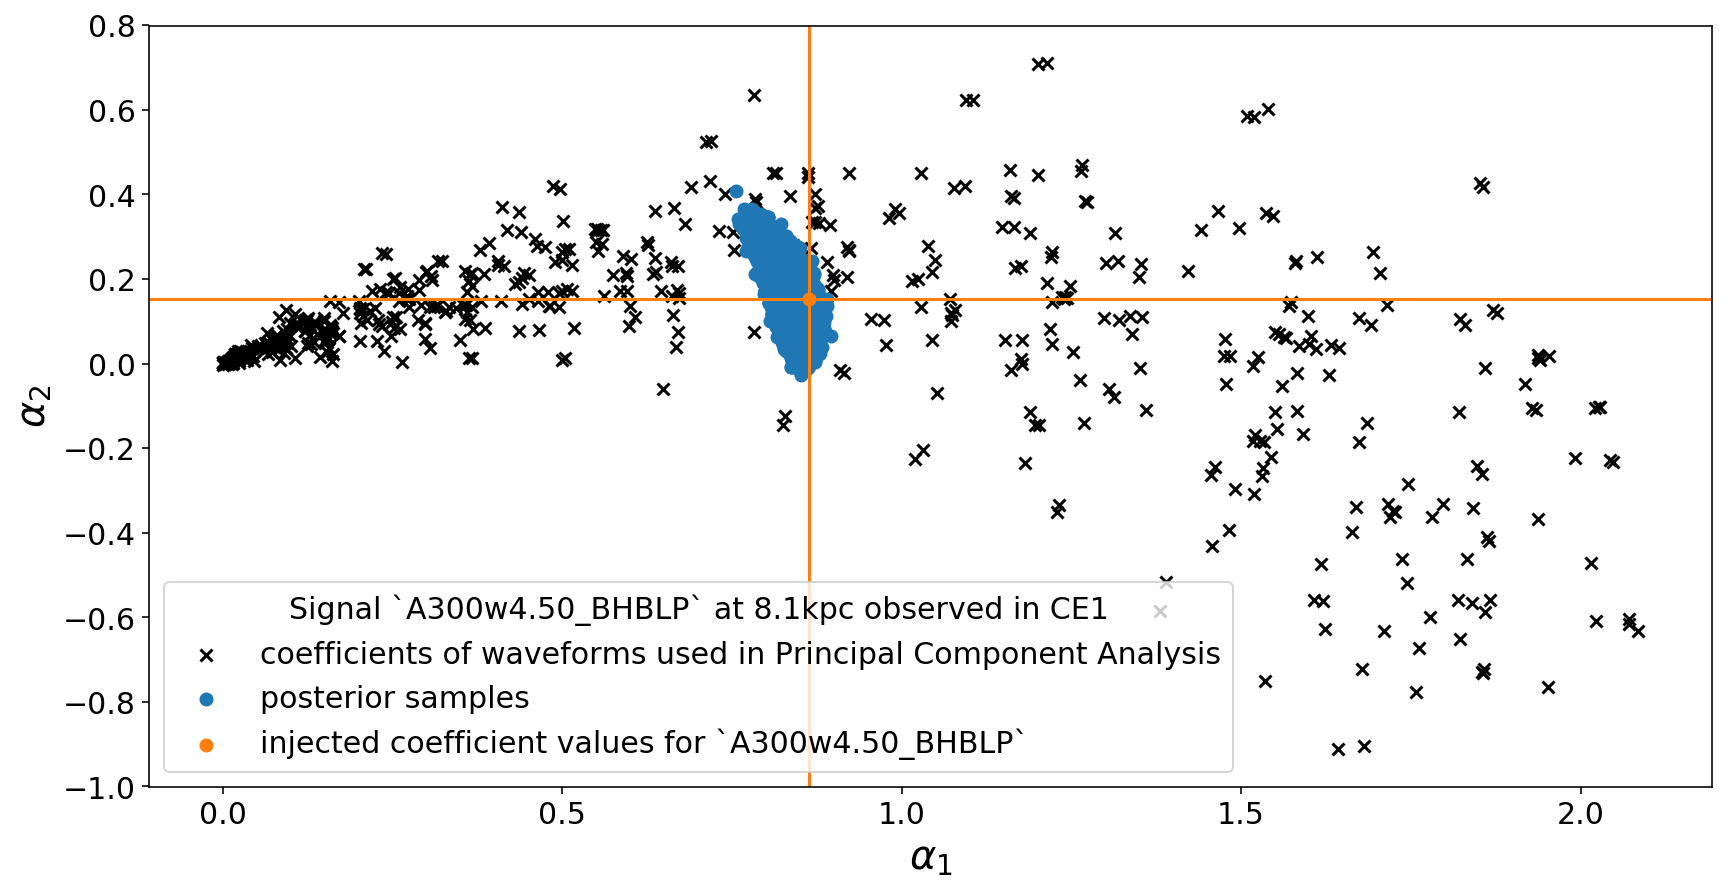

In [11]:
samples = extract_samples_from_posteriors('posterior_files/{}_0.0081_{}.hdf'.format(det, key))
plt.scatter(coeffs[:,0], coeffs[:,1],
            c='k', marker='x', label='coefficients of waveforms used in Principal Component Analysis')
plt.scatter(samples['coeff_0'], samples['coeff_1'], 
            c='#1f77b4', label='posterior samples')

plt.scatter(inj_coeff0_dict[key], inj_coeff1_dict[key], c='#ff7f0e', label='injected coefficient values for `{}`'.format(key))
plt.axvline(inj_coeff0_dict[key], color='#ff7f0e')
plt.axhline(inj_coeff1_dict[key], color='#ff7f0e')
plt.ylabel(r'$\alpha_2$', fontsize=20)
plt.xlabel(r'$\alpha_1$', fontsize=20)
plt.legend(loc='best', title='Signal `{}` at 8.1kpc observed in CE1'.format(key))
plt.show()

[0.02730465 0.02769843 0.02738061 ... 0.02798209 0.02787906 0.02791986]


/home/chaitanya.afle/src/pycbc/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\beta$')

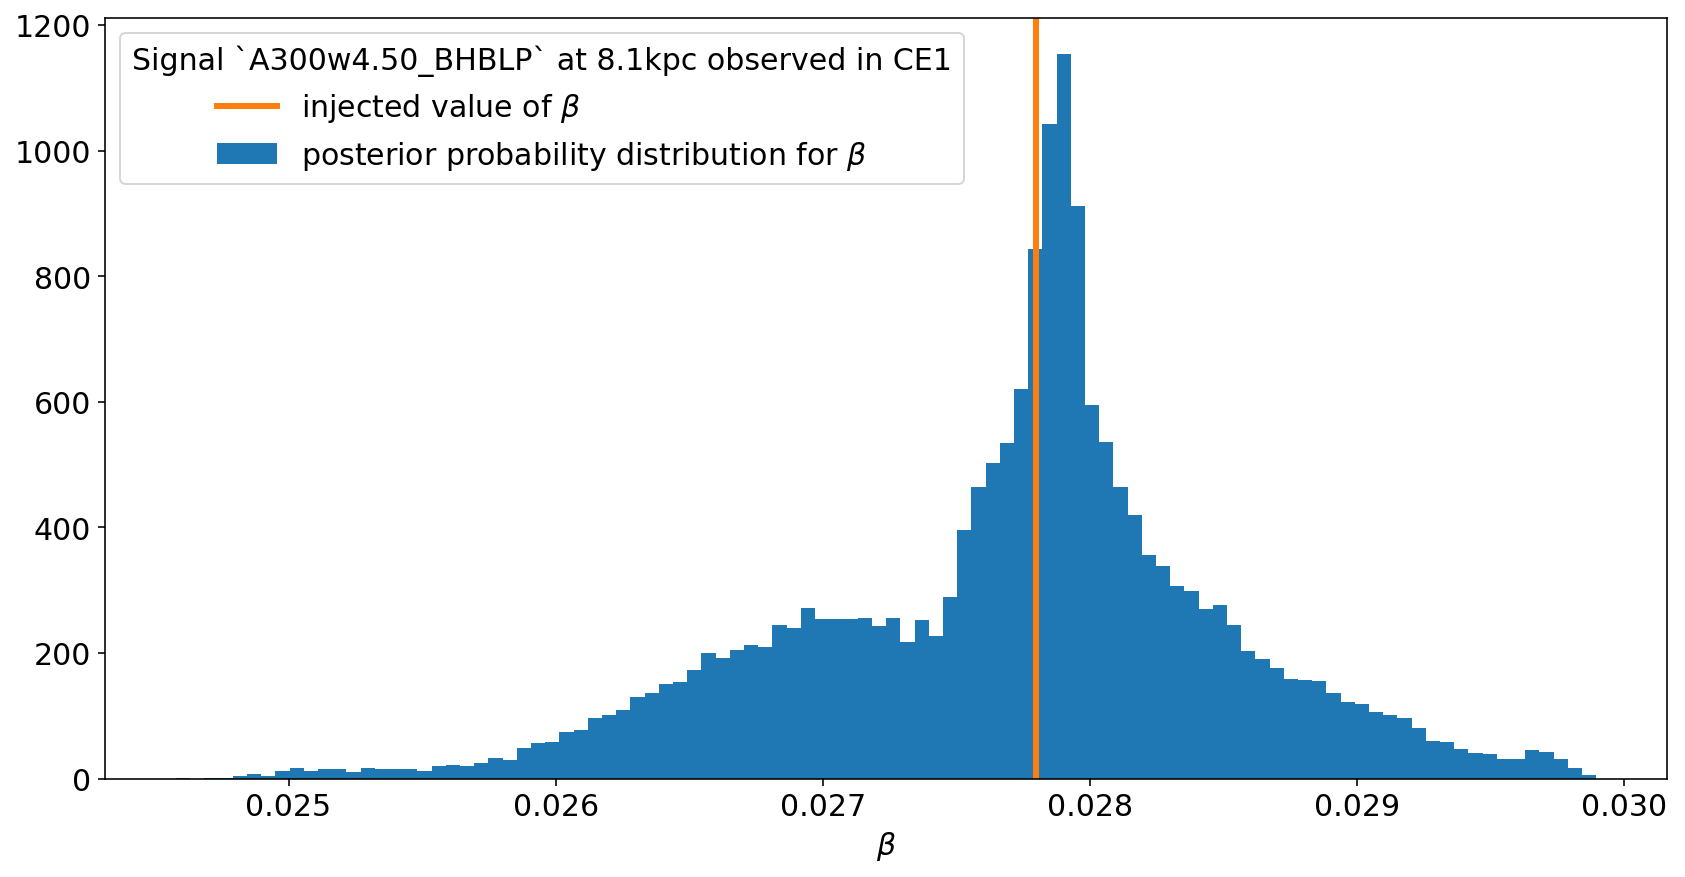

In [12]:
beta = get_beta_from_alpha1_alpha_2(key, det, pc_alpha1, pc_alpha2, pc_betas)
print(beta)
plt.hist(beta, bins=100, color='#1f77b4', normed=True,
         label=r'posterior probability distribution for $\beta$')
plt.axvline(inj_betas_dict[key], color='#ff7f0e', linewidth=3,
            label=r'injected value of $\beta$')
plt.legend(loc='best', title='Signal `{}` at 8.1kpc observed in CE1'.format(key))
plt.xlabel(r'$\beta$')

Text(0.5,0,'$f_{\\mathrm{peak}}$')

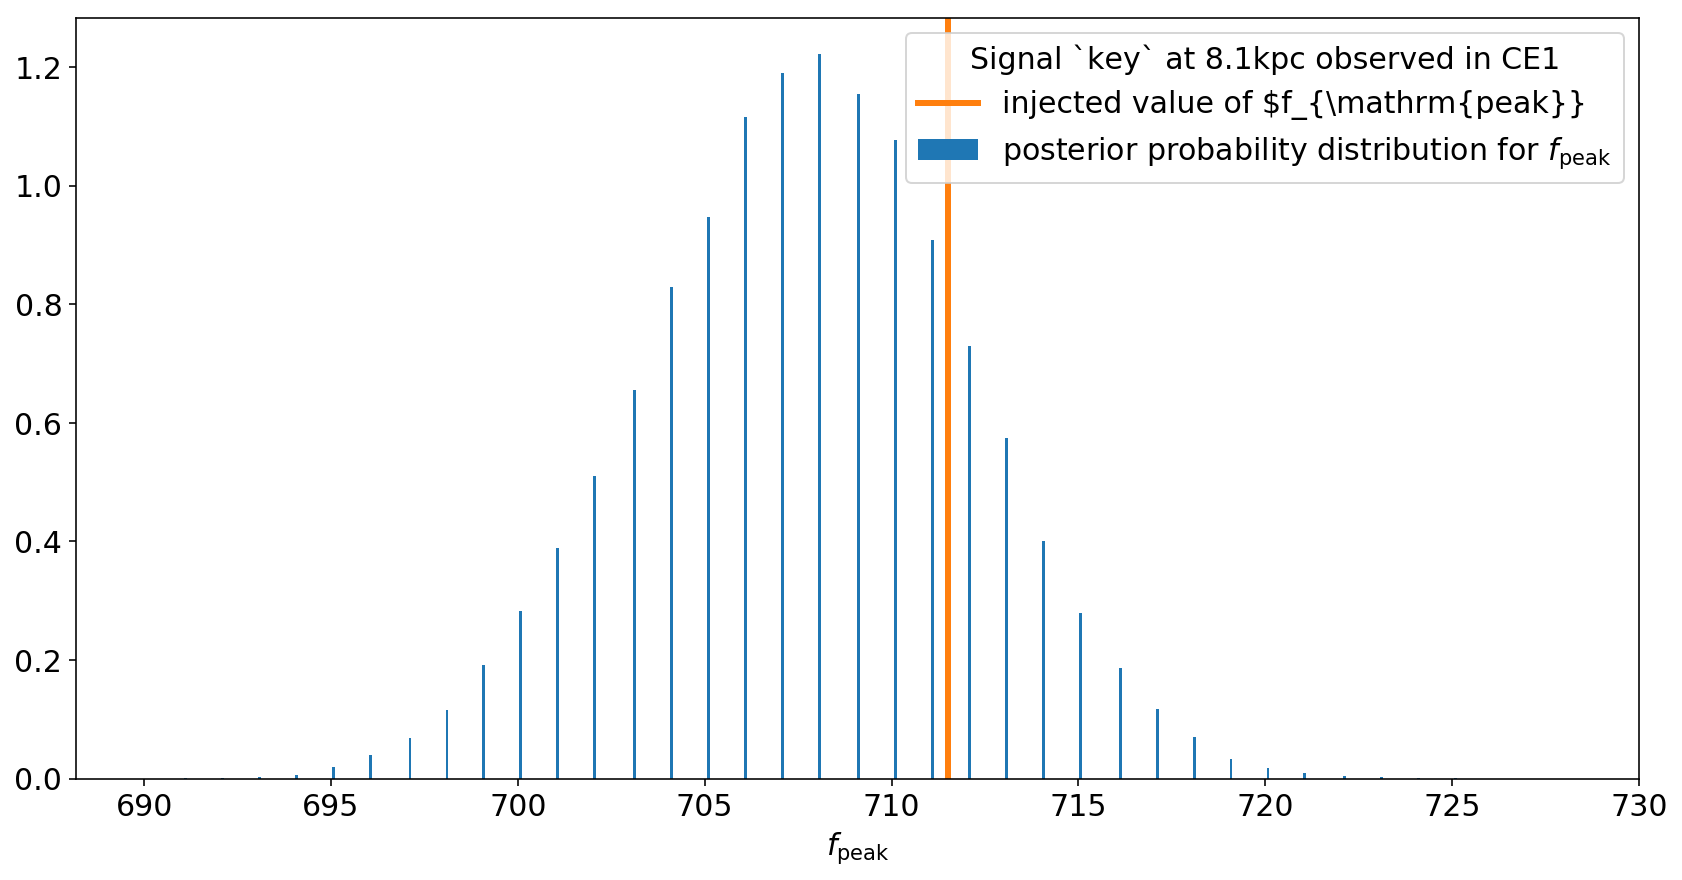

In [13]:
fpeak = get_f_peak_from_strain(key, det, time_axis, delta_t, 600., 1075., pcs)
plt.hist(fpeak, bins=500, color='#1f77b4', normed=True,
         label=r'posterior probability distribution for $f_{\mathrm{peak}}$')
plt.axvline(inj_fpeaks_dict[key], color='#ff7f0e', linewidth=3,
            label=r'injected value of $f_{\mathrm{peak}}')
plt.legend(loc='best', title='Signal `key` at 8.1kpc observed in CE1'.format(key))
plt.xlabel(r'$f_{\mathrm{peak}}$')

SNR < 8 for A467w3.00_SFHx to be observed in aLIGO at 8.1 kpc


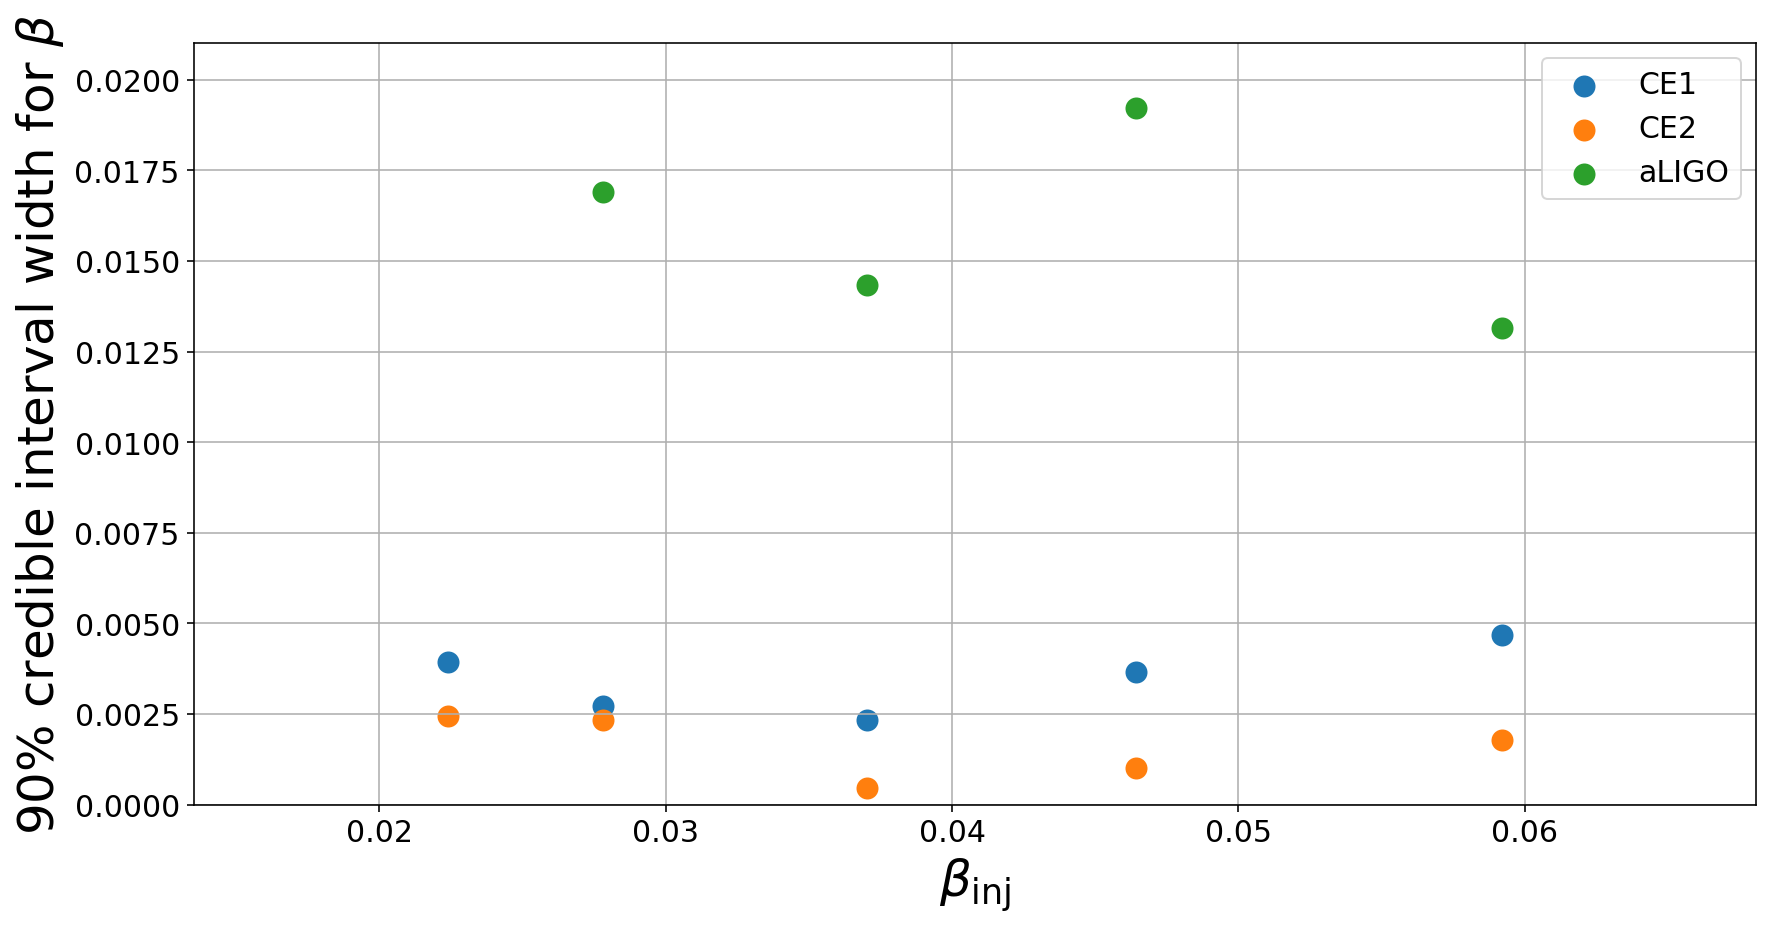

In [14]:
color_dict = {'CE1' : '#1f77b4', 'CE2' : '#ff7f0e', 'aLIGO' : '#2ca02c'}

detectors = ['CE1' , 'CE2', 'aLIGO']

for det in detectors:
    inj_beta = []
    rec_beta_credible_interval = []
    for key in keys:
        try:
            beta = get_beta_from_alpha1_alpha_2(key, det, pc_alpha1, pc_alpha2, pc_betas)
            inj_beta.append(inj_betas_dict[key])
            beta_5 = numpy.percentile(beta, 5)
            beta_95 = numpy.percentile(beta, 95)
            rec_beta_credible_interval.append(beta_95-beta_5)
        except:
            print("SNR < 8 for {} to be observed in {} at 8.1 kpc".format(key, det))
    
    plt.scatter(inj_beta, rec_beta_credible_interval, s=100,
                color=color_dict[det], label='{}'.format(det))
    
plt.ylabel(r'90% credible interval width for $\beta$', fontsize=25)
plt.xlabel(r'$\beta_{\mathrm{inj}}$', fontsize=25)
plt.ylim(0.0, 0.021)
plt.legend(loc='best')
plt.grid(True)